In [1]:
FILE_NAME = 'magazine_dataset.csv'

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import datetime

from sklearn.preprocessing import MinMaxScaler

%load_ext tensorboard
print(tf.__version__)

2.0.0


In [2]:
# split dataset 80% train, 15% validation, 5% dev
def split_dataset(dataset):
    size = dataset.shape[0]
    train_size = size * 80 // 100
    test_size = size * 15 // 100
    
    return dataset[0:train_size, :], dataset[train_size:(train_size + test_size), :], dataset[(train_size + test_size):size, :]

def plot_series(time, series, lab, form='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], form, label=lab)
    plt.xlabel("Minuto")
    plt.ylabel("Preço")
    plt.grid(True)

def tf_dataset(series_x, series_y, batch_size, shuffle_buffer, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    if shuffle:
        ds = ds.cache().shuffle(shuffle_buffer).batch(batch_size).repeat()
    else:
        ds = ds.cache().batch(batch_size).repeat()

    return ds

def create_window_dataset(ds, lb, window_size):
    windowed_dataset = []
    labels = []
    for i in range(window_size, ds.shape[0] + 1):
        windowed_dataset.append(ds[i - window_size:i])
        labels.append(lb[i - 1])
        
    return np.array(windowed_dataset), np.array(labels)

In [50]:
data = pd.read_csv(FILE_NAME, sep=',')
data = data[['open', 'high', 'low', 'close', 'dollar_close', 'volume', 'close']]
data.columns.values[6] = "y"
data.head()

,open,high,low,close,dollar_close,volume,y
0,33.0013,33.0316,32.7213,32.8513,4.1007,0,32.8513
1,32.8810,33.1225,32.8522,33.0411,4.0994,301337,33.0411
2,33.0200,33.3100,33.0200,33.1300,4.0979,177100,33.1300
3,33.1506,33.1761,32.9759,33.0006,4.0971,179428,33.0006
4,33.0012,33.1010,32.9008,32.9112,4.0974,204443,32.9112


In [51]:
dataset = data['y']
dataset.loc[dataset.shape[0]]= 0.0
dataset = dataset.iloc[1:]
data.iloc[:, -1] = dataset.values
dataset = data[:-1]

dataset_to_numpy = dataset.values
dataset.head()

,open,high,low,close,dollar_close,volume,y
0,33.0013,33.0316,32.7213,32.8513,4.1007,0,33.0411
1,32.8810,33.1225,32.8522,33.0411,4.0994,301337,33.1300
2,33.0200,33.3100,33.0200,33.1300,4.0979,177100,33.0006
3,33.1506,33.1761,32.9759,33.0006,4.0971,179428,32.9112
4,33.0012,33.1010,32.9008,32.9112,4.0974,204443,32.8800


# Split dataset

In [52]:
train_dataset, cross_validation_dataset, dev_dataset = split_dataset(dataset_to_numpy)

print("Dataset shape: {:s}".format(str(dataset_to_numpy.shape)))
print("Train dataset shape: {:s}".format(str(train_dataset.shape)))
print("Cross validation dataset shape: {:s}".format(str(cross_validation_dataset.shape)))
print("Dev dataset shape: {:s}".format(str(dev_dataset.shape)))

Dataset shape: (11796, 7)
Train dataset shape: (9436, 7)
Cross validation dataset shape: (1769, 7)
Dev dataset shape: (591, 7)


# Stock prices graph

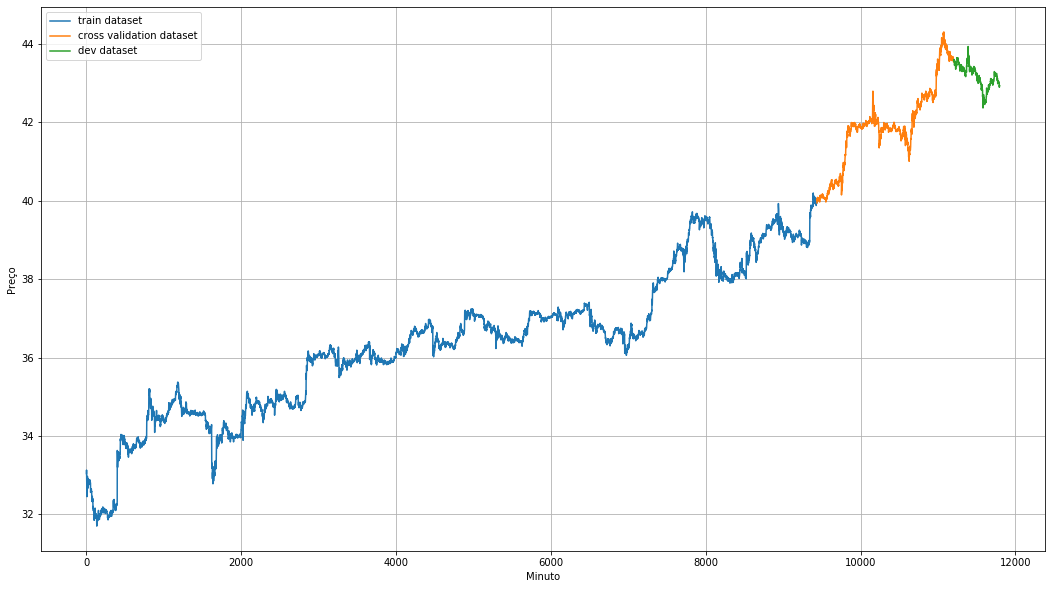

In [53]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(train_dataset.shape[0]), train_dataset[:, -1], "train dataset")
plot_series(np.arange(train_dataset.shape[0], (cross_validation_dataset.shape[0] + train_dataset.shape[0])), cross_validation_dataset[:, -1], "cross validation dataset")
plot_series(np.arange((cross_validation_dataset.shape[0] + train_dataset.shape[0]), (cross_validation_dataset.shape[0]+ train_dataset.shape[0] + dev_dataset.shape[0])), dev_dataset[:, -1], "dev dataset")
plt.legend(loc='upper left')

# Data normalization

In [54]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_dataset[:, 0:-1])

train_dataset_normalized = scaler.transform(train_dataset[:, 0:-1])
cross_validation_dataset_normalized = scaler.transform(cross_validation_dataset[:, 0:-1])
dev_dataset_normalized = scaler.transform(dev_dataset[:, 0:-1])

# Create window dataset

In [55]:
WINDOW_SIZE = 15
BATCH_SIZE = 64

windowed_dataset_train, labels_train = create_window_dataset(train_dataset[:, 0:-1], train_dataset[:, -1], WINDOW_SIZE)

windowed_dataset_train, labels_train = create_window_dataset(train_dataset_normalized, train_dataset[:, -1], WINDOW_SIZE)
train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000)
unshuffled_train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000, False)

windowed_dataset_validation, labels_validation = create_window_dataset(cross_validation_dataset_normalized, cross_validation_dataset[:, -1], WINDOW_SIZE)
cross_validation_set = tf_dataset(windowed_dataset_validation, labels_validation, BATCH_SIZE, 1000, False)

windowed_dataset_dev, labels_dev = create_window_dataset(dev_dataset_normalized, dev_dataset[:, -1], WINDOW_SIZE)
# for i in range(1,160):
#     if windowed_dataset_dev.shape[0] % i == 0:
#         dev_batch = i
dev_set = tf_dataset(windowed_dataset_dev, labels_dev, 1, 1000, False)

In [56]:
TRAIN_STEP = math.ceil(windowed_dataset_train.shape[0] / BATCH_SIZE)
VALIDATION_STEP = math.ceil(windowed_dataset_validation.shape[0] / BATCH_SIZE)
DEV_STEP = windowed_dataset_dev.shape[0]

# Define model

In [59]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           strides=1,
                           padding="causal",
                           activation="relu",
                           input_shape=windowed_dataset_train.shape[-2:]),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.LSTM(192, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                             decay_steps=1000000,
                                                             decay_rate=0.98,
                                                             staircase=False)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15, 64)            1984      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 13, 192)           172800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 13, 128)           164352    
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0

# Train model

In [ ]:
class StopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('loss') < 0.28 and logs.get('val_loss') < 0.165:
            print("\nReached the desired validation error so cancelling training!")
            self.model.stop_training = True

stop_callback = StopCallback()

log_dir = "logs\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_set,
                    epochs=1500,
                    steps_per_epoch=TRAIN_STEP,
                    validation_data=cross_validation_set,
                    validation_steps=VALIDATION_STEP,
                    verbose=1,
                    callbacks=[stop_callback, tensorboard_callback])

Train for 148 steps, validate for 28 steps
Epoch 1/1500
148/148 [==============================] - 8s 51ms/step - loss: 202.2317 - mae: 9.8059 - val_loss: 9.0281 - val_mae: 2.7900
Epoch 2/1500
148/148 [==============================] - 2s 15ms/step - loss: 25.2428 - mae: 3.9932 - val_loss: 7.4561 - val_mae: 2.5249
Epoch 3/1500
148/148 [==============================] - 2s 15ms/step - loss: 18.5101 - mae: 3.4129 - val_loss: 15.8014 - val_mae: 3.8553
Epoch 4/1500
148/148 [==============================] - 2s 15ms/step - loss: 13.4195 - mae: 2.8987 - val_loss: 0.9193 - val_mae: 0.8000
Epoch 5/1500
148/148 [==============================] - 2s 15ms/step - loss: 12.0388 - mae: 2.7246 - val_loss: 3.5252 - val_mae: 1.7489
Epoch 6/1500
148/148 [==============================] - 2s 16ms/step - loss: 11.0964 - mae: 2.6063 - val_loss: 6.6702 - val_mae: 2.4849
Epoch 7/1500
148/148 [==============================] - 3s 18ms/step - loss: 10.9533 - mae: 2.5854 - val_loss: 3.1890 - val_mae: 1.6445
Epo

148/148 [==============================] - 2s 16ms/step - loss: 4.4085 - mae: 1.6080 - val_loss: 1.9580 - val_mae: 1.2217
Epoch 60/1500
148/148 [==============================] - 2s 15ms/step - loss: 4.3168 - mae: 1.5998 - val_loss: 1.4753 - val_mae: 0.9937
Epoch 61/1500
148/148 [==============================] - 3s 17ms/step - loss: 4.3494 - mae: 1.6116 - val_loss: 1.8165 - val_mae: 1.1605
Epoch 62/1500
148/148 [==============================] - 3s 19ms/step - loss: 4.1951 - mae: 1.5820 - val_loss: 1.8793 - val_mae: 1.1731
Epoch 63/1500
148/148 [==============================] - 3s 20ms/step - loss: 4.1503 - mae: 1.5723 - val_loss: 1.9614 - val_mae: 1.2463
Epoch 64/1500
148/148 [==============================] - 2s 15ms/step - loss: 3.9241 - mae: 1.5272 - val_loss: 2.8728 - val_mae: 1.5855
Epoch 65/1500
148/148 [==============================] - 2s 15ms/step - loss: 3.9672 - mae: 1.5324 - val_loss: 2.8353 - val_mae: 1.5582
Epoch 66/1500
148/148 [==============================] - 2s 15

148/148 [==============================] - 2s 16ms/step - loss: 1.7482 - mae: 1.0127 - val_loss: 2.2647 - val_mae: 1.3734
Epoch 120/1500
148/148 [==============================] - 2s 16ms/step - loss: 1.6880 - mae: 1.0061 - val_loss: 1.3269 - val_mae: 0.9610
Epoch 121/1500
148/148 [==============================] - 2s 14ms/step - loss: 1.7034 - mae: 1.0048 - val_loss: 1.5168 - val_mae: 1.0587
Epoch 122/1500
148/148 [==============================] - 2s 14ms/step - loss: 1.6977 - mae: 1.0086 - val_loss: 2.3286 - val_mae: 1.3716
Epoch 123/1500
148/148 [==============================] - 2s 17ms/step - loss: 1.6576 - mae: 0.9985 - val_loss: 1.9969 - val_mae: 1.2394
Epoch 124/1500
148/148 [==============================] - 2s 15ms/step - loss: 1.6588 - mae: 1.0042 - val_loss: 1.9378 - val_mae: 1.2320
Epoch 125/1500
148/148 [==============================] - 2s 15ms/step - loss: 1.6505 - mae: 0.9941 - val_loss: 1.8163 - val_mae: 1.1987
Epoch 126/1500
148/148 [==============================] 

Epoch 179/1500
 81/148 [===============>..............] - ETA: 0s - loss: 0.5750 - mae: 0.5888

## Save model weights

In [40]:
model.save_weights('weights/model_weights.ckpt')

## Load model weights

In [13]:
model.load_weights('weights/model_weights.ckpt')

# Predictions

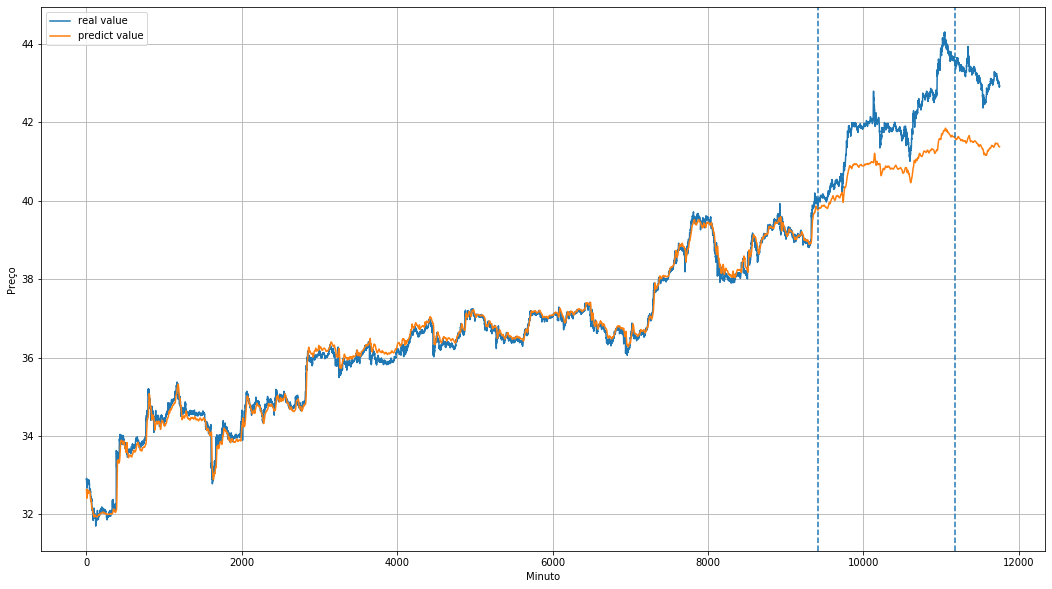

In [48]:
forecast_train = model.predict(unshuffled_train_set, steps=TRAIN_STEP)
forecast_validation = model.predict(cross_validation_set, steps=VALIDATION_STEP)
forecast_dev = model.predict(dev_set, steps=DEV_STEP)

total_forecast = np.concatenate((forecast_train[:,0], forecast_validation[:,0], forecast_dev[:,0]))
total_labels = np.concatenate((labels_train, labels_validation, labels_dev))

plt.figure(figsize=(18, 10))
plot_series(np.arange(total_labels.shape[0]), total_labels, "real value")
plot_series(np.arange(total_labels.shape[0]), total_forecast, "predict value")
xpositions = [labels_train.shape[0], (labels_train.shape[0] + labels_validation.shape[0])]
for xp in xpositions:
    plt.axvline(x=xp, linestyle='--')
plt.legend(loc='upper left')

## Predictions: Train data

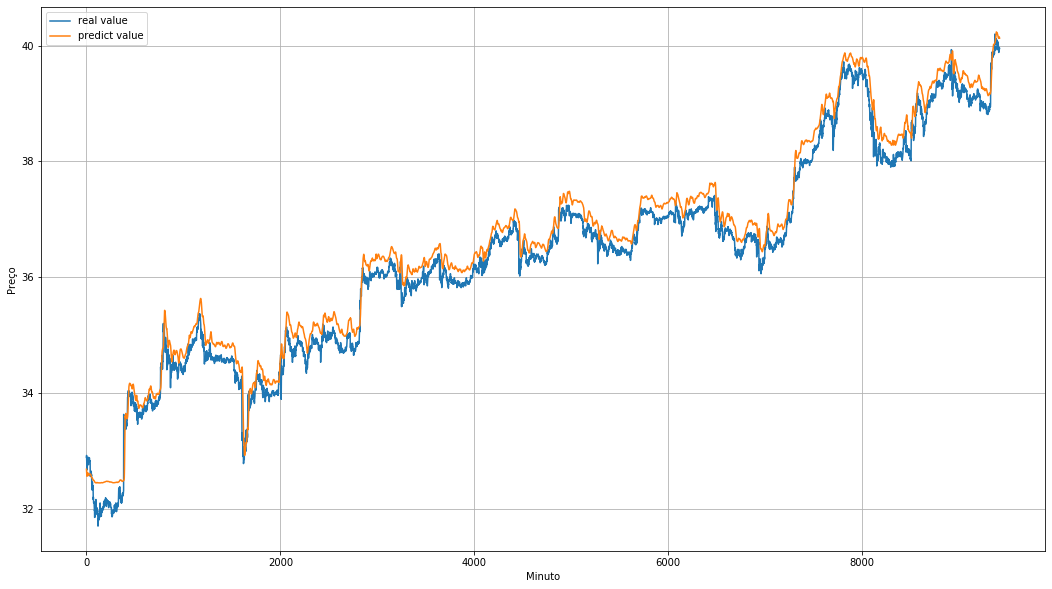

In [44]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_train.shape[0]), labels_train, "real value")
plot_series(np.arange(labels_train.shape[0]), forecast_train[:,0], "predict value")
plt.legend(loc='upper left')

## Predictions: Validation data

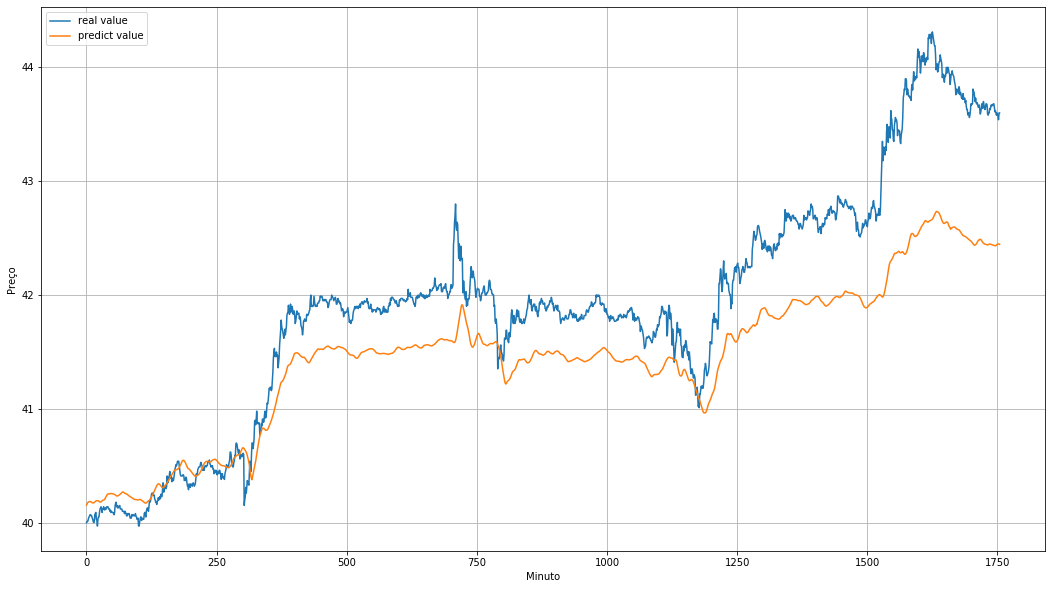

In [45]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_validation.shape[0]), labels_validation, "real value")
plot_series(np.arange(labels_validation.shape[0]), forecast_validation[:,0], "predict value")
plt.legend(loc='upper left')

## Predictions: Dev data

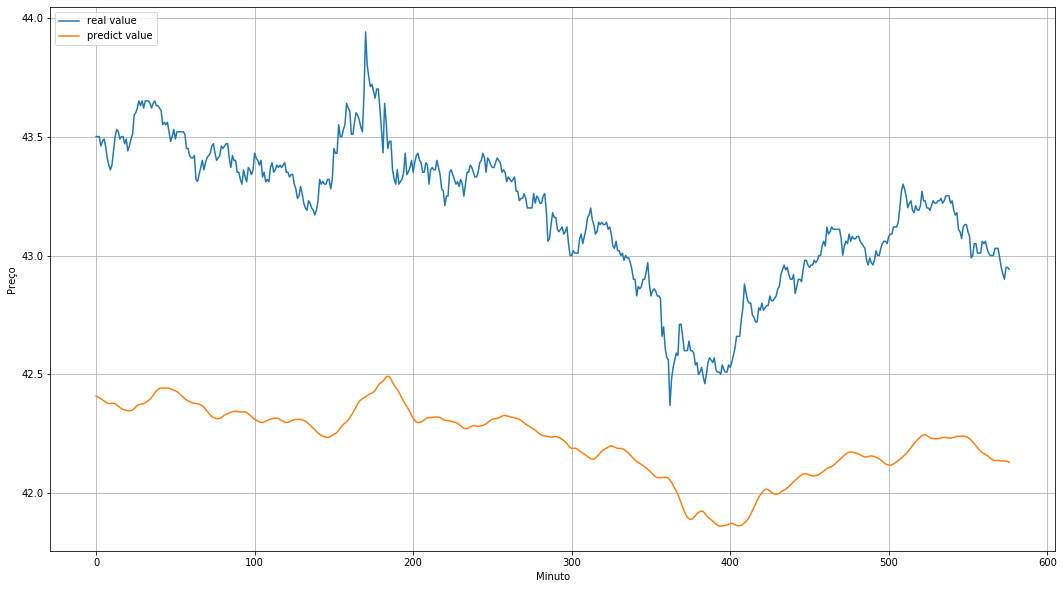

In [46]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_dev.shape[0]), labels_dev, "real value")
plot_series(np.arange(labels_dev.shape[0]), forecast_dev[:,0], "predict value")
plt.legend(loc='upper left')